In [1]:
!pip install torchmultimodal-nightly datasets transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.3 MB/s

In [2]:
!wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
!tar xf vocab.tar.gz

--2023-11-17 03:57:37--  http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596389 (582K) [application/gzip]
Saving to: ‘vocab.tar.gz’

vocab.tar.gz        100%[===================>] 582.41K  --.-KB/s    in 0.03s   

2023-11-17 03:57:37 (17.9 MB/s) - ‘vocab.tar.gz’ saved [596389/596389]



In [3]:
from itertools import islice

with open("vocabs/answers_textvqa_more_than_1.txt") as f:
  vocab = f.readlines()

print(f"Vocab: {vocab[:5]}")
print(f"vocab len: {len(vocab)}")

answer_to_idx = {}
for idx, entry in enumerate(vocab):
  answer_to_idx[entry.strip("\n")] = idx
print(list(islice(answer_to_idx, 5)))

Vocab: ['<unk>\n', 'nokia\n', 'ec\n', 'virgin\n', '2011\n']
vocab len: 3997
['<unk>', 'nokia', 'ec', 'virgin', '2011']


In [4]:
from datasets import load_dataset
dataset = load_dataset("textvqa")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/34602 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5734 [00:00<?, ? examples/s]

Question: what type of plane is this?
Answers: ['lape', 'cargo', 'ec-agg', 'lape', 'lape', 'lape', 'lape', 'lape', 'lape', 'airplane']


<function matplotlib.pyplot.show(close=None, block=None)>

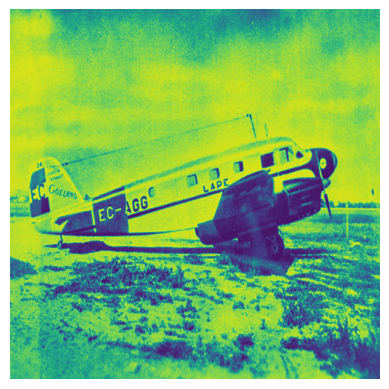

In [7]:
import matplotlib.pyplot as plt
import numpy as np
idx = 1
print(f"Question: {dataset['train'][idx]['question']}")
print(f"Answers: {dataset['train'][idx]['answers']}")

im = np.array(dataset['train'][idx]['image'].resize((500,500)))
plt.imshow(im)
plt.axis('off')
plt.show

In [11]:
import torch
from torchvision import transforms
from collections import defaultdict
from transformers import BertTokenizer
from functools import partial
import torchmultimodal

def transform(tokenizer, input):
  batch = {}
  image_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize([224, 224])
  ])
  image = image_transform(input['image'][0].convert('RGB'))
  batch['image'] = [image]

  tokenized = tokenizer(input["question"], return_tensors="pt", padding="max_length", max_length= 512)
  batch.update(tokenized)

  ans_to_count = defaultdict(int)
  for ans in input['answers'][0]:
    ans_to_count[ans] += 1
  max_value = max(ans_to_count, key=ans_to_count.get)
  ans_idx = answer_to_idx.get(max_value, 0)
  batch['answers'] = torch.as_tensor([ans_idx])
  return batch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", padding="max_length", max_length=512)
transform = partial(transform, tokenizer)
dataset.set_transform(transform)

In [9]:
from torchmultimodal.models.flava.model import flava_model_for_classification
model = flava_model_for_classification(num_classes=len(vocab))

flava_for_pretraining_unified_text_encoder.pt: 1.43GB [00:13, 103MB/s]                            


In [13]:
from torch import nn
BATCH_SIZE = 2
MAX_STEPS = 3
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset['train'], batch_size=BATCH_SIZE)
optimizer = torch.optim.AdamW(model.parameters())

epochs = 1
for _ in range(epochs):
  for idx, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    out = model(text= batch["input_ids"], image= batch["image"], labels=batch["answers"])
    loss = out.loss
    loss.backward()
    optimizer.step()
    print(f"Loss at step {idx} = {loss}")
    if idx >= MAX_STEPS-1:
      break



Loss at step 0 = 8.27518367767334
Loss at step 1 = 8.297407150268555
Loss at step 2 = 8.393143653869629
